<a href="https://colab.research.google.com/github/dogakurtoglu/DSA210/blob/main/EDA(Exploratory_Data_Analysis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from tabulate import tabulate
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
#in case of any forgotten imports i used them all here

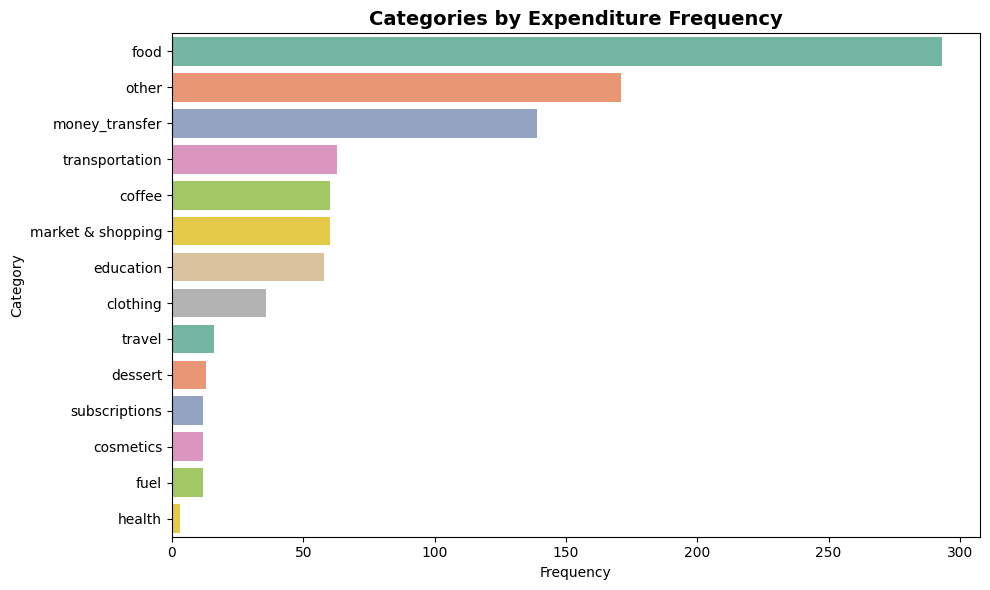

In [ ]:
# 1. uploading data
df_kategorili = pd.read_csv("harcama_kategorili_aciklama_ve_tutar.csv")

# 2. graph drawings
plt.figure(figsize=(10,6))
sns.countplot(
    data=df_kategorili,
    y="Kategori",
    order=df_kategorili["Kategori"].value_counts().index,
    palette="Set2"
)

# 3. headers
plt.title("Categories by Expenditure Frequency", fontsize=14, weight="bold")
plt.xlabel("Frequency")
plt.ylabel("Category")
plt.tight_layout()
plt.show()



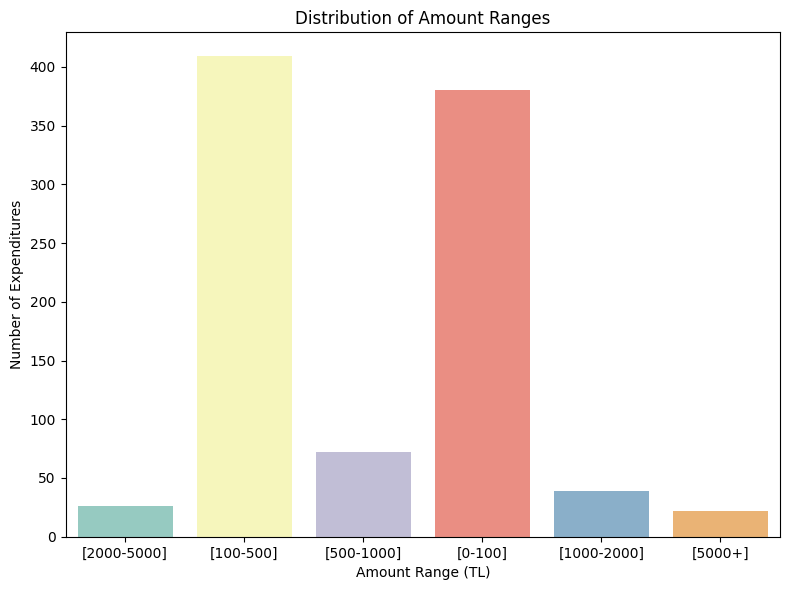

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_kategorili, x="Tutar Aralığı", palette="Set3")

plt.title("Distribution of Amount Ranges")
plt.ylabel("Number of Expenditures")
plt.xlabel("Amount Range (TL)")

plt.tight_layout()
plt.show()


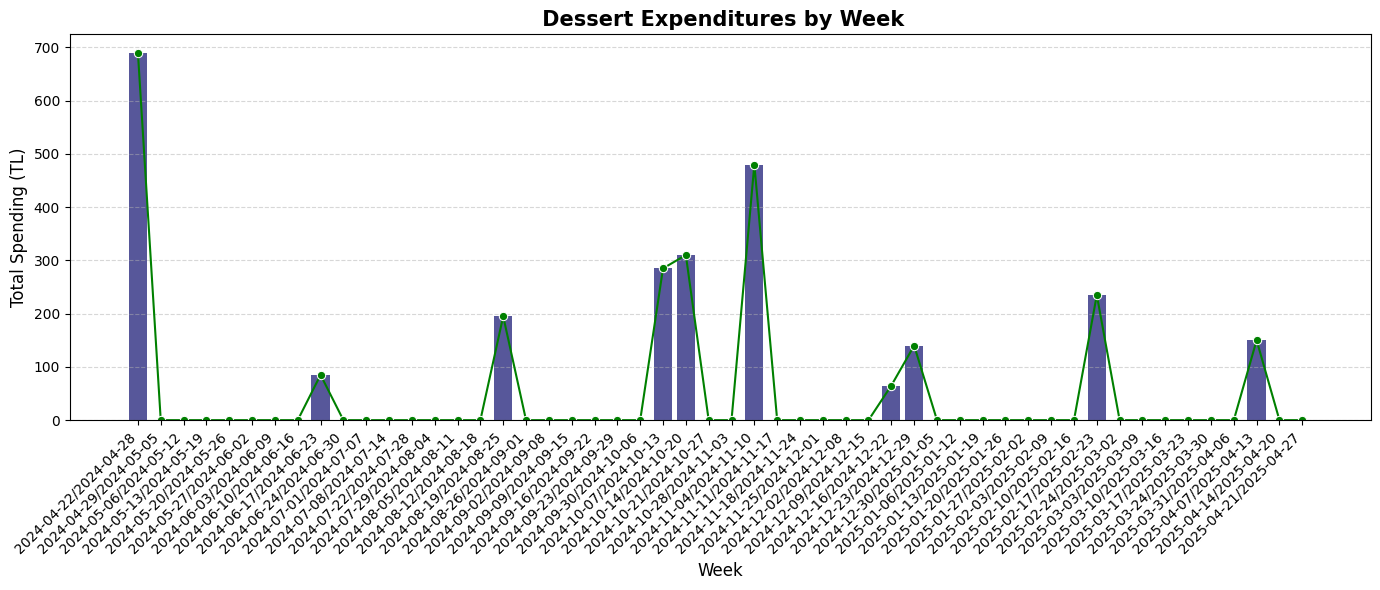

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# --- Step 1: Load the categorized spending dataset ---
df = pd.read_csv("harcama_kategorili_aciklama_ve_tutar.csv")

# --- Step 2: Convert the 'date' column to datetime format ---
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# --- Step 3: Normalize category names for consistent filtering ---
df["Kategori"] = df["Kategori"].str.lower().str.strip()

# --- Step 4: Create a custom weekly label using start and end dates of each week ---
df["Hafta"] = df["date"].dt.to_period("W").apply(
    lambda r: f"{r.start_time.date()}/{r.end_time.date()}"
)

# --- Step 5: Extract all unique weeks and sort them ---
tum_haftalar = df["Hafta"].dropna().unique()
tum_haftalar = pd.Series(tum_haftalar).sort_values()

# --- Step 6: Filter only dessert transactions ---
dessert_df = df[df["Kategori"] == "dessert"]

# --- Step 7: Aggregate weekly total dessert spending ---
haftalik_tatli = (
    dessert_df
    .groupby("Hafta")["İşlem Tutarı*"]
    .sum()
    .abs()
    .reindex(tum_haftalar, fill_value=0)
    .reset_index()
)

# Rename columns
haftalik_tatli.columns = ["Week", "Total Dessert Spending"]

# --- Step 8: Plot the weekly dessert expenditure ---
plt.figure(figsize=(14, 6))

# Barplot to show total weekly spending
sns.barplot(
    data=haftalik_tatli,
    x="Week",
    y="Total Dessert Spending",
    color="navy",
    alpha=0.7
)

# Lineplot to show weekly trend
sns.lineplot(
    data=haftalik_tatli,
    x="Week",
    y="Total Dessert Spending",
    color="green",
    marker="o"
)

# --- Step 9: Styling ---
plt.title(" Dessert Expenditures by Week", fontsize=15, weight="bold")
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Spending (TL)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


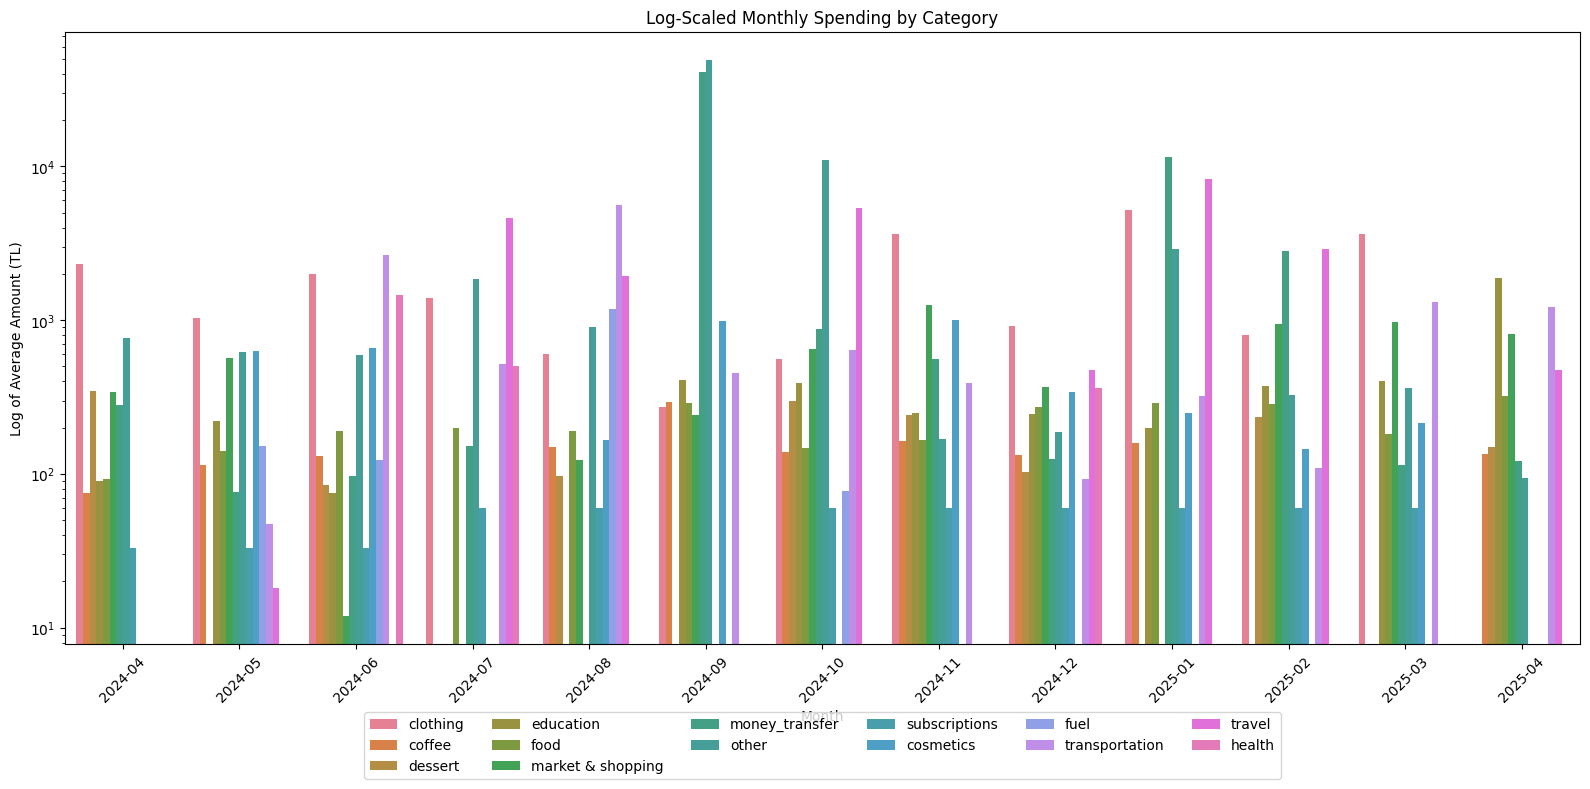

In [ ]:
# upload CSV
df = pd.read_csv("harcama_kategorili_aciklama_ve_tutar.csv")

# organizde the date column
df.rename(columns={"Tarih/Saat": "date"}, inplace=True)
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# addition of monthly periods
df["month"] = df["date"].dt.to_period("M")

# based on category monthly expenditures
monthly_cat_avg = df.groupby(["month", "Kategori"])["İşlem Tutarı*"].mean().abs().reset_index()

# Log-scale barplot
plt.figure(figsize=(16, 8))
sns.barplot(data=monthly_cat_avg, x="month", y="İşlem Tutarı*", hue="Kategori")

plt.yscale("log")
plt.title("Log-Scaled Monthly Spending by Category")
plt.xlabel("Month")
plt.ylabel("Log of Average Amount (TL)")
plt.xticks(rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
plt.tight_layout()
plt.show()


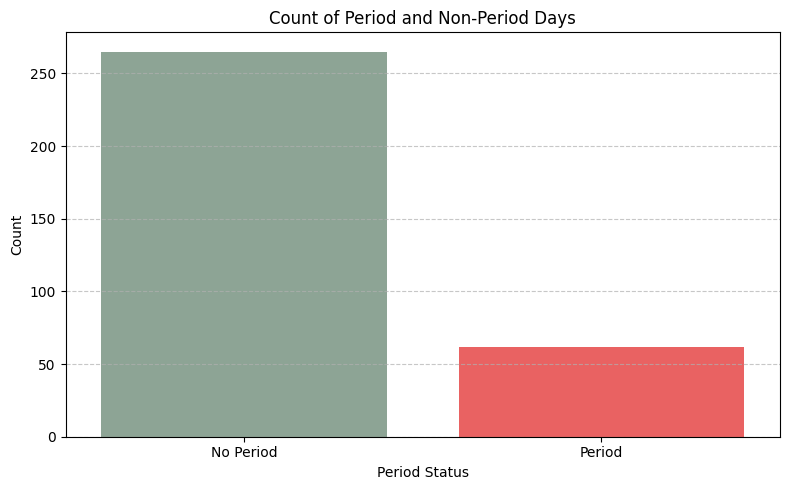

In [ ]:
df = pd.read_csv("daily_phase_series.csv")

# format the date
df['date'] = pd.to_datetime(df['date'])

# create is_period flag
df['is_period'] = df['phase'].apply(lambda x: 1 if x == "Menstruation" else 0)
df['Period Highlight'] = df['is_period'].replace({1: "Period", 0: "No Period"})

# colouring
period_colors = {
    "Period": "#FF4C4C",       # red
    "No Period": "#89A894"     # green
}

# get the numbers for Barplot
period_counts = df['Period Highlight'].value_counts()

# Graph
plt.figure(figsize=(8, 5))
sns.barplot(
    x=period_counts.index,
    y=period_counts.values,
    palette=[period_colors[label] for label in period_counts.index]
)
plt.title("Count of Period and Non-Period Days")
plt.xlabel("Period Status")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

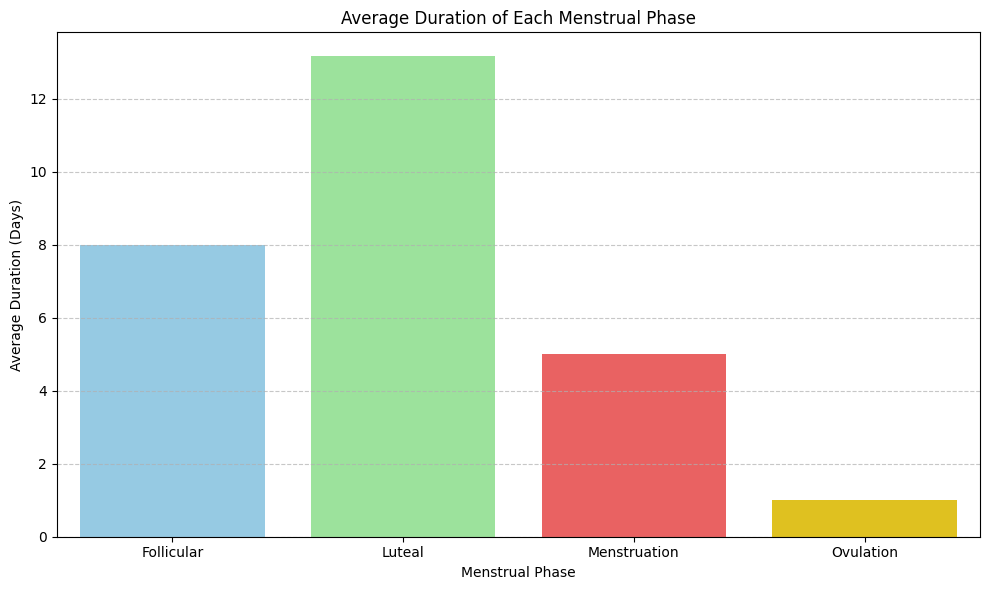

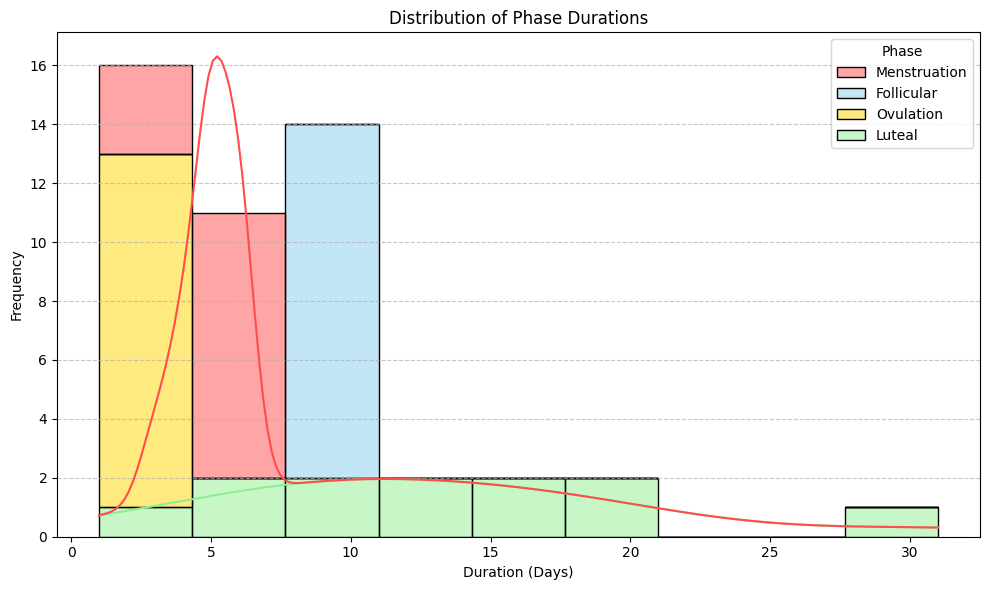

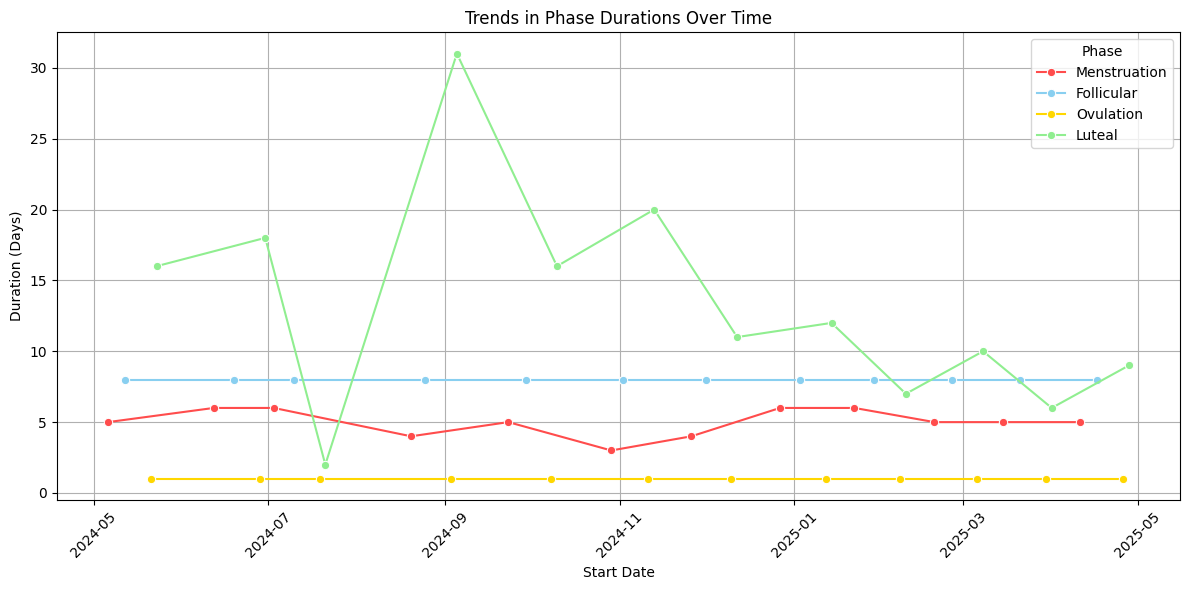

In [ ]:
# defining of the colour palette
palette = {
    "Menstruation": "#FF4C4C",
    "Follicular": "#89CFF0",
    "Ovulation": "#FFD700",
    "Luteal": "#90EE90"
}

# upload CSV
data = pd.read_csv("phase_date_ranges.csv")

# get the dates
data['Start Date'] = pd.to_datetime(data['Start Date'], errors='coerce')
data['End Date'] = pd.to_datetime(data['End Date'], errors='coerce')

# clean the wrong date rows
invalid_rows = data[data['End Date'] < data['Start Date']]
if not invalid_rows.empty:
    print("Invalid rows detected and removed:")
    print(invalid_rows)
    data = data[data['End Date'] >= data['Start Date']]

# calculate days
data['Duration (Days)'] = (data['End Date'] - data['Start Date']).dt.days

# calculate negative values
data = data[data['Duration (Days)'] >= 0]

# if data is empty print an error
if data.empty:
    print("No valid data to visualize after cleaning.")
else:
    # Bar Chart: mean duration
    avg_duration = data.groupby('Phase')['Duration (Days)'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=avg_duration, x='Phase', y='Duration (Days)', palette=palette)
    plt.title("Average Duration of Each Menstrual Phase")
    plt.xlabel("Menstrual Phase")
    plt.ylabel("Average Duration (Days)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Histogram: distribution of the phase durations
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='Duration (Days)', hue='Phase', kde=True, palette=palette, multiple="stack")
    plt.title("Distribution of Phase Durations")
    plt.xlabel("Duration (Days)")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

  #Line Chart: Trend of Phase Durations Over Time

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x='Start Date', y='Duration (Days)', hue='Phase', marker='o', palette=palette)
    plt.title("Trends in Phase Durations Over Time")
    plt.xlabel("Start Date")
    plt.ylabel("Duration (Days)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend(title="Phase")
    plt.tight_layout()
    plt.show()


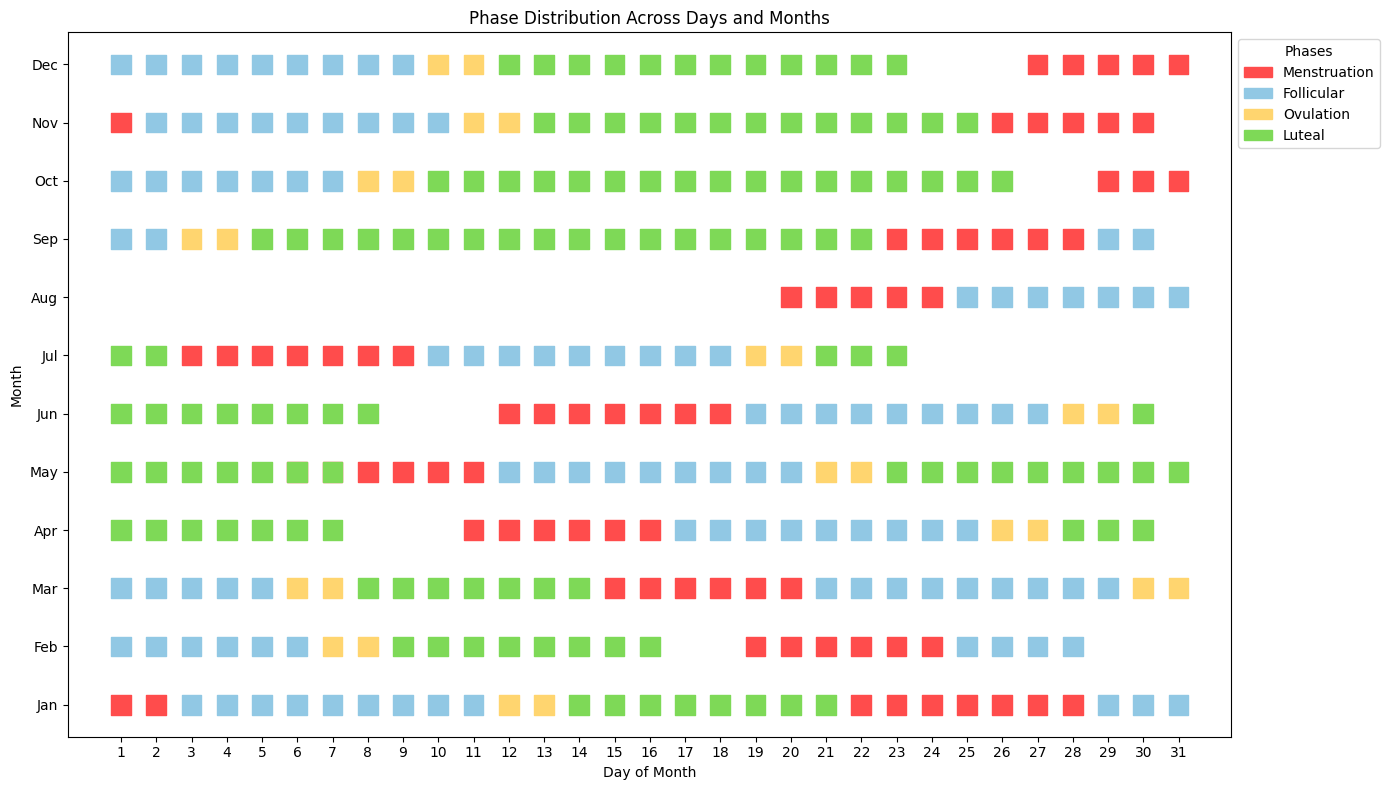

In [ ]:
# --- 1. read files ---
phases_data = pd.read_csv("phase_date_ranges.csv", parse_dates=["Start Date", "End Date"])
all_dates_with_flags = pd.read_csv("daily_phase_series.csv", parse_dates=["date"])  # İsteğe bağlı, burada kullanılmadı

# --- 2. create date ranges ---
all_dates = pd.date_range(start=phases_data['Start Date'].min(), end=phases_data['End Date'].max(), freq='D')

# --- 3. define phases for each day---
phase_matrix = []
for single_date in all_dates:
    phase = None
    for _, row in phases_data.iterrows():
        if row['Start Date'] <= single_date <= row['End Date']:
            phase = row['Phase']
            break
    phase_matrix.append(phase)

# --- 4. Create DataFrame  ---
phase_matrix_df = pd.DataFrame({'Date': all_dates, 'Phase': phase_matrix})
phase_matrix_df['Month'] = phase_matrix_df['Date'].dt.month
phase_matrix_df['Day'] = phase_matrix_df['Date'].dt.day

# --- according to phases the color codes ---
phase_colors = {
    "Menstruation": "#FF4C4C",
    "Follicular": "#91C8E4",
    "Ovulation": "#FFD56F",
    "Luteal": "#7ED957"
}

# --- 6. Visulalization Phase-Matrix ---
fig, ax = plt.subplots(figsize=(14, 8))
colors = [phase_colors.get(phase, "white") for phase in phase_matrix_df['Phase']]

ax.scatter(phase_matrix_df['Day'], phase_matrix_df['Month'], c=colors, s=200, marker='s')

ax.set_xticks(range(1, 32))
ax.set_xticklabels(range(1, 32))
ax.set_yticks(range(1, 13))
ax.set_yticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

ax.set_xlabel("Day of Month")
ax.set_ylabel("Month")
ax.set_title("Phase Distribution Across Days and Months")

legend_patches = [mpatches.Patch(color=color, label=phase) for phase, color in phase_colors.items()]
plt.legend(handles=legend_patches, loc="upper left", bbox_to_anchor=(1, 1), title="Phases")

plt.tight_layout()
plt.show()


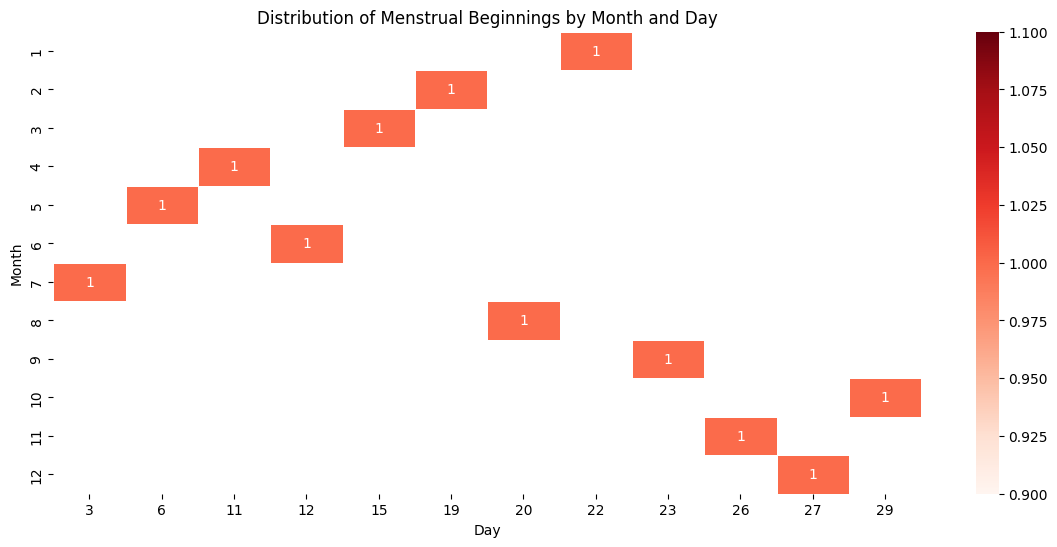

In [ ]:
# get the begining of the cycle from phase_matrix_df DataFrame
menstruation_starts = phases_data[phases_data["Phase"] == "Menstruation"]["Start Date"]

heat_df = pd.DataFrame({
    "day": menstruation_starts.dt.day,
    "month": menstruation_starts.dt.month
})

heat_pivot = heat_df.value_counts().reset_index(name='count')
heat_matrix = heat_pivot.pivot(index="month", columns="day", values="count")

plt.figure(figsize=(14, 6))
sns.heatmap(heat_matrix, cmap="Reds", linewidths=0.5, annot=True, fmt=".0f")
plt.title("Distribution of Menstrual Beginnings by Month and Day")
plt.xlabel("Day")
plt.ylabel("Month")
plt.show()


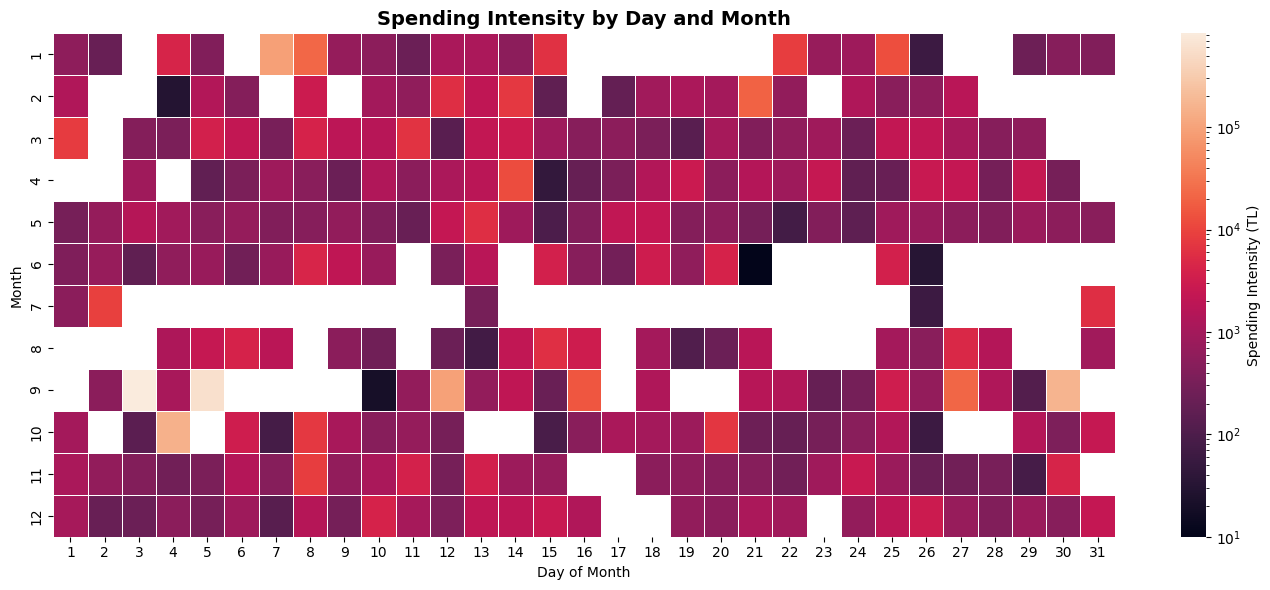

In [ ]:
# --- Step 1: Load the daily phase data and categorized spending data ---
fazdf = pd.read_csv("final_daily_cycle_table.csv")
harcama_df = pd.read_csv("harcama_kategorili_aciklama_ve_tutar.csv")

# --- Step 2: Clean column names and convert date columns to datetime format ---
harcama_df.columns = harcama_df.columns.str.strip()
fazdf.columns = fazdf.columns.str.strip()

harcama_df.rename(columns={"Tarih/Saat": "date"}, inplace=True)
harcama_df["date"] = pd.to_datetime(harcama_df["date"], dayfirst=True)
fazdf["date"] = pd.to_datetime(fazdf["date"])

# --- Step 3: Merge the spending and phase data on the 'date' column ---
combined = pd.merge(harcama_df, fazdf, on="date", how="left")

# --- Step 4: Extract day and month information for grouping ---
combined["day"] = combined["date"].dt.day
combined["month"] = combined["date"].dt.month

# --- Step 5: Create a pivot table with total absolute daily spending per month-day ---
pivot = (
    combined
    .groupby(["month", "day"])["İşlem Tutarı*"]
    .sum()
    .abs()
    .unstack(fill_value=0)
)

# --- Step 6: Visualize as a heatmap using logarithmic color scaling ---
plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot,
    cmap="rocket",
    linewidths=0.5,
    norm=LogNorm(),  # handles skewed spending values
    cbar_kws={'label': 'Spending Intensity (TL)'}
)
plt.title("Spending Intensity by Day and Month", fontsize=14, weight='bold')
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.tight_layout()
plt.show()


In [ ]:
harcama = pd.read_csv("harcama_kategorili_aciklama_ve_tutar.csv")
faz = pd.read_csv("final_daily_cycle_table.csv")

# normalize the dates
harcama["date"] = pd.to_datetime(harcama["date"]).dt.normalize()
faz["date"] = pd.to_datetime(faz["date"]).dt.normalize()

# Merge
merged = pd.merge(harcama, faz, on="date", how="left")

# control: Unknown phase left?
print(merged["phase"].value_counts(dropna=False))



phase
Luteal          352
Follicular      236
Menstruation    156
NaN              87
Unknown          64
Ovulation        53
Name: count, dtype: int64


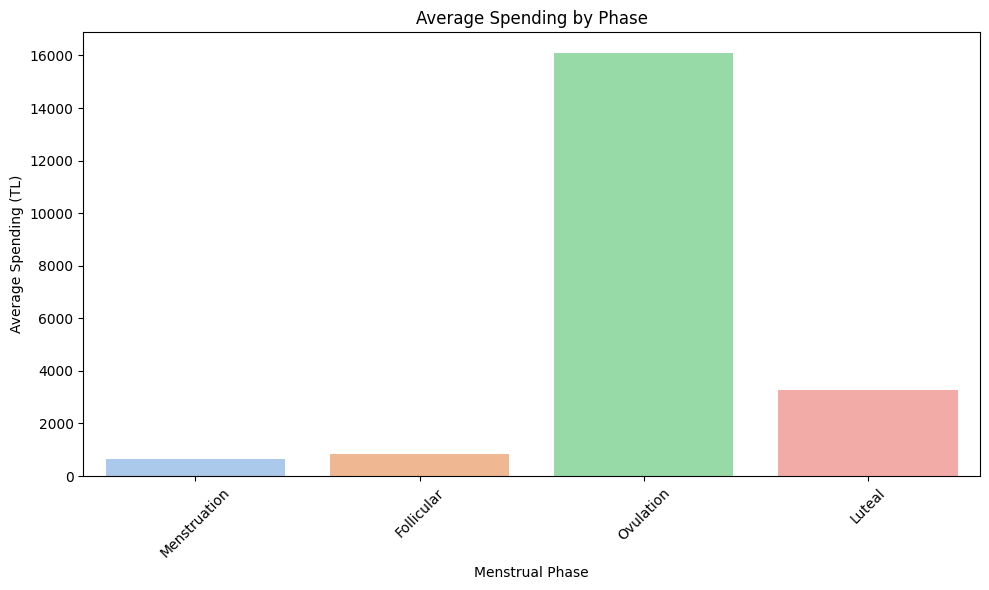

In [ ]:
# --- define the phase ordering---
phase_order = ["Menstruation", "Follicular", "Ovulation", "Luteal"]

# --- calculate avrg expenditures based on phases ---
phase_avg_spending = (
    merged.groupby("phase")["İşlem Tutarı*"]
    .mean()
    .abs()
    .reindex(phase_order)
)

# --- visualize ---
plt.figure(figsize=(10, 6))
sns.barplot(x=phase_avg_spending.index, y=phase_avg_spending.values, palette="pastel")
plt.title("Average Spending by Phase")
plt.xlabel("Menstrual Phase")
plt.ylabel("Average Spending (TL)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


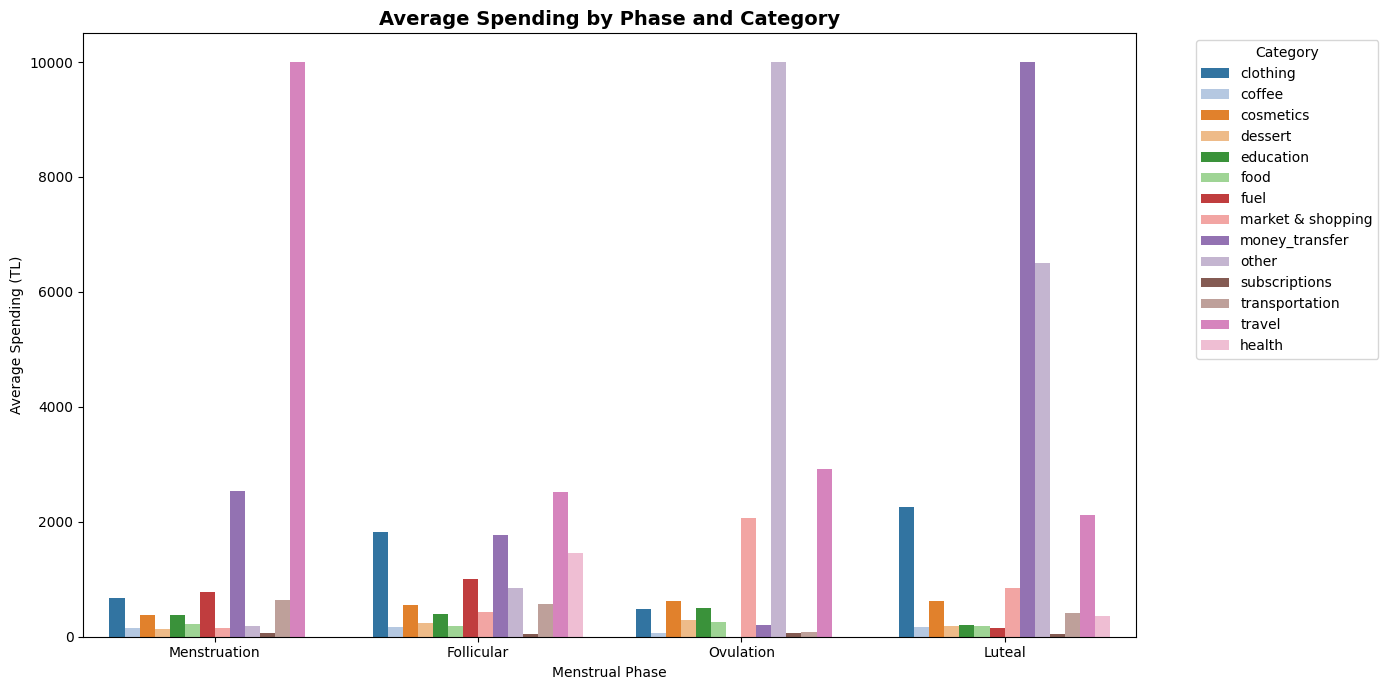

In [ ]:
# --- Define phase order for consistent axis representation ---
phase_order = ["Menstruation", "Follicular", "Ovulation", "Luteal"]

# --- Step 1: Compute average (absolute) spending by menstrual phase and category ---
phase_cat_avg = (
    merged
    .groupby(["phase", "Kategori"])["İşlem Tutarı*"]
    .mean()
    .abs()  # Take absolute values to account for negative entries
    .reset_index()
)

# --- Step 2: Ensure correct phase ordering on the x-axis ---
phase_cat_avg["phase"] = pd.Categorical(phase_cat_avg["phase"], categories=phase_order, ordered=True)
phase_cat_avg = phase_cat_avg.sort_values(["phase", "Kategori"])

# --- Step 3: Clip high outlier averages for better visual scaling ---
limit = 10000  # Upper limit to prevent extremely high values from skewing the plot
phase_cat_avg["İşlem Tutarı*"] = phase_cat_avg["İşlem Tutarı*"].clip(upper=limit)

# --- Step 4: Define a distinct, high-contrast color palette ---
distinct_palette = sns.color_palette("tab20", n_colors=phase_cat_avg["Kategori"].nunique())

# --- Step 5: Create the grouped bar plot ---
plt.figure(figsize=(14, 7))
sns.barplot(
    data=phase_cat_avg,
    x="phase",
    y="İşlem Tutarı*",
    hue="Kategori",
    palette=distinct_palette
)

# --- Step 6: Styling the chart ---
plt.title("Average Spending by Phase and Category", fontsize=14, weight="bold")
plt.xlabel("Menstrual Phase")
plt.ylabel("Average Spending (TL)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


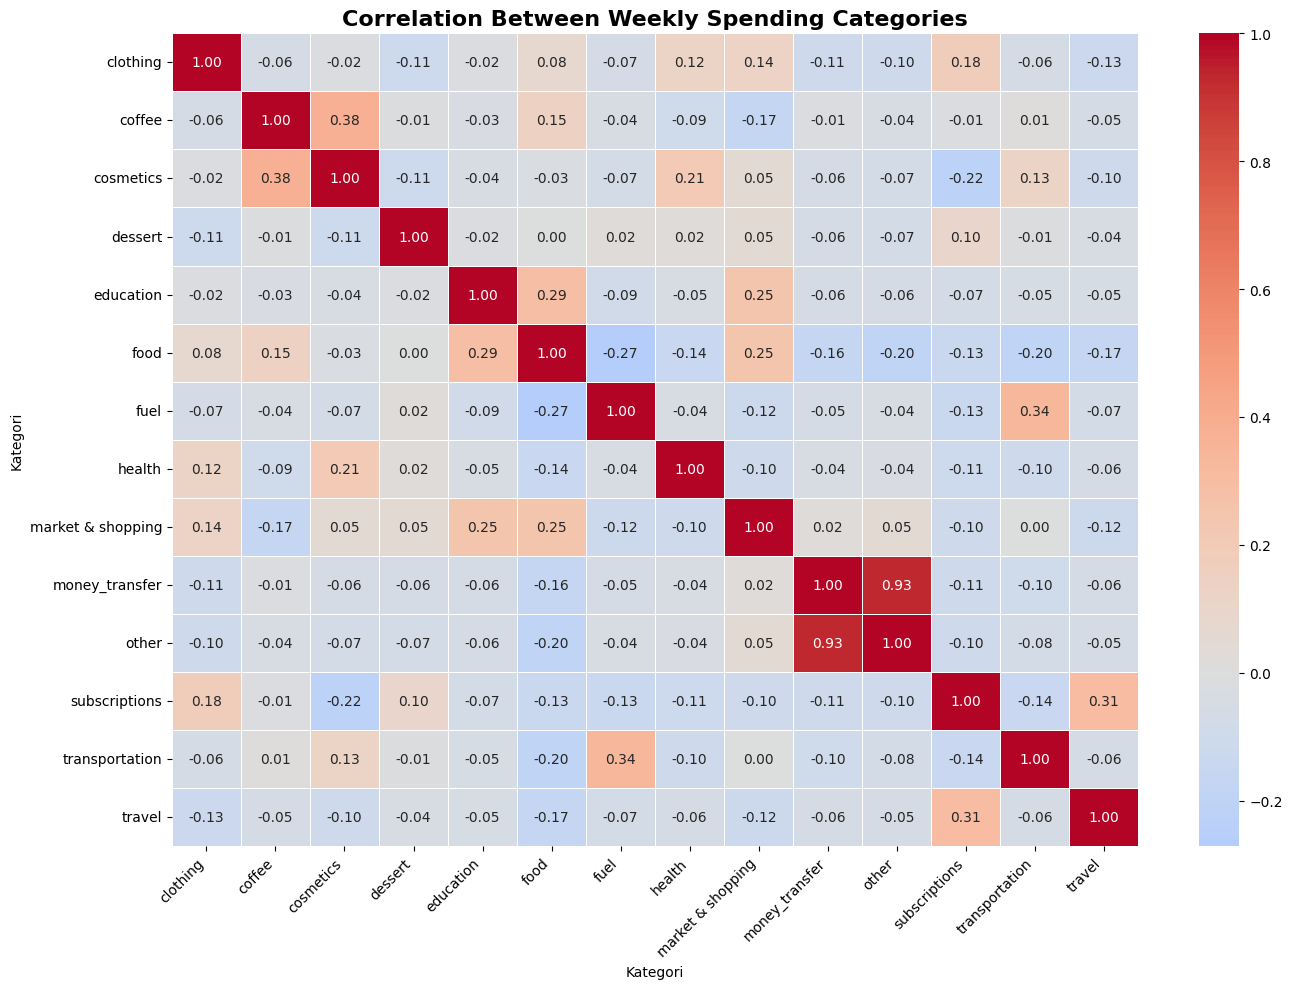

In [ ]:
# --- Step 1: Extract the start date of each week from the date column ---
# This will be used to group data by week
merged["week"] = pd.to_datetime(merged["date"]).dt.to_period("W").apply(lambda r: r.start_time)

# --- Step 2: Aggregate total weekly spending per category (absolute values) ---
# Negative transactions are converted to absolute to reflect real expenditure
weekly_totals = (
    merged
    .groupby(["week", "Kategori"])["İşlem Tutarı*"]
    .sum()
    .abs()
    .unstack(fill_value=0)  # Create a pivoted table: weeks as rows, categories as columns
)

# --- Step 3: Compute the correlation matrix between all category columns ---
correlation_matrix = weekly_totals.corr()

# --- Step 4: Visualize the correlation matrix as a heatmap ---
plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,             # Show correlation coefficients inside the boxes
    cmap="coolwarm",        # Diverging color palette from negative to positive
    center=0,               # Center the color scale at 0
    fmt=".2f",              # Format numbers with 2 decimals
    linewidths=0.5          # Add gridlines between cells
)

# --- Step 5: Final plot styling ---
plt.title("Correlation Between Weekly Spending Categories", fontsize=16, weight="bold")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# --- Step 1: Compute the correlation matrix of weekly spending data ---
correlation_matrix = weekly_totals.corr()

# --- Step 2: Extract the upper triangle of the matrix to avoid duplicate pairs ---
# Use NumPy's triu (triangle upper) mask and apply it to the correlation matrix
sorted_pairs = (
    correlation_matrix
    .where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))  # keep only upper triangle
    .stack()  # collapse to long format (pairwise index)
    .sort_values(ascending=False)  # sort by correlation strength
)

# --- Step 3: Print the top 10 most correlated category pairs ---
print("📌 Top 10 Most Correlated Weekly Spending Category Pairs:")
print(sorted_pairs.head(10))


📌 Top 10 Most Correlated Weekly Spending Category Pairs:
Kategori        Kategori         
money_transfer  other                0.929210
coffee          cosmetics            0.383040
fuel            transportation       0.340669
subscriptions   travel               0.309239
education       food                 0.294792
food            market & shopping    0.249362
education       market & shopping    0.247535
cosmetics       health               0.209694
clothing        subscriptions        0.176408
coffee          food                 0.145753
dtype: float64


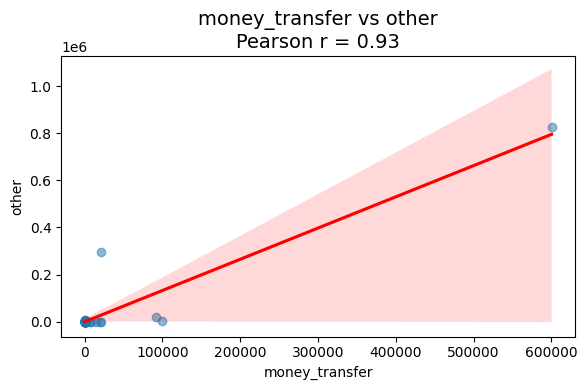

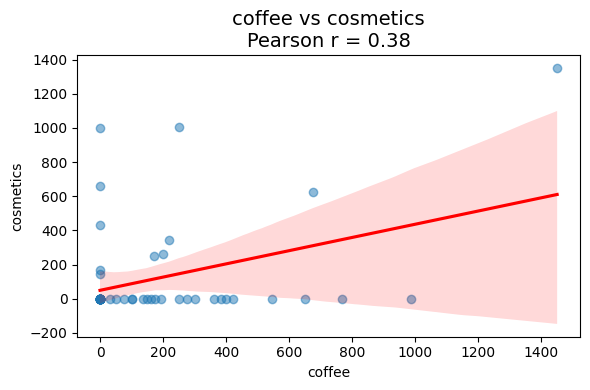

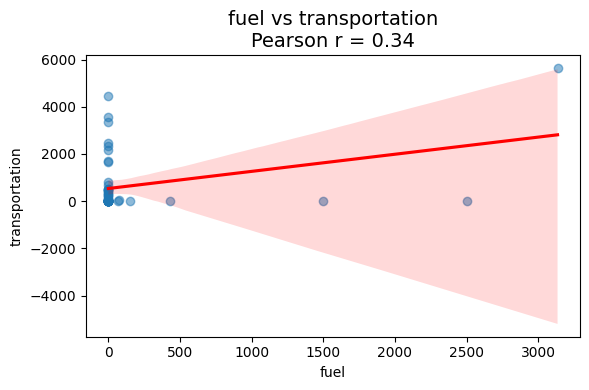

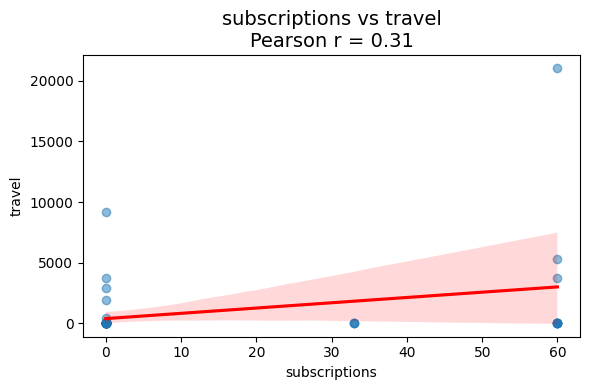

In [ ]:
# get the top 4 corell
top_4_pairs = sorted_pairs.head(4)

# draw new graphs for every pair
for (cat1, cat2), corr_value in top_4_pairs.items():
    plt.figure(figsize=(6, 4))
    sns.regplot(data=weekly_totals, x=cat1, y=cat2, line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5})

    r_val, p_val = pearsonr(weekly_totals[cat1], weekly_totals[cat2])
    plt.title(f"{cat1} vs {cat2}\nPearson r = {r_val:.2f}", fontsize=14)
    plt.xlabel(cat1)
    plt.ylabel(cat2)
    plt.tight_layout()
    plt.show()



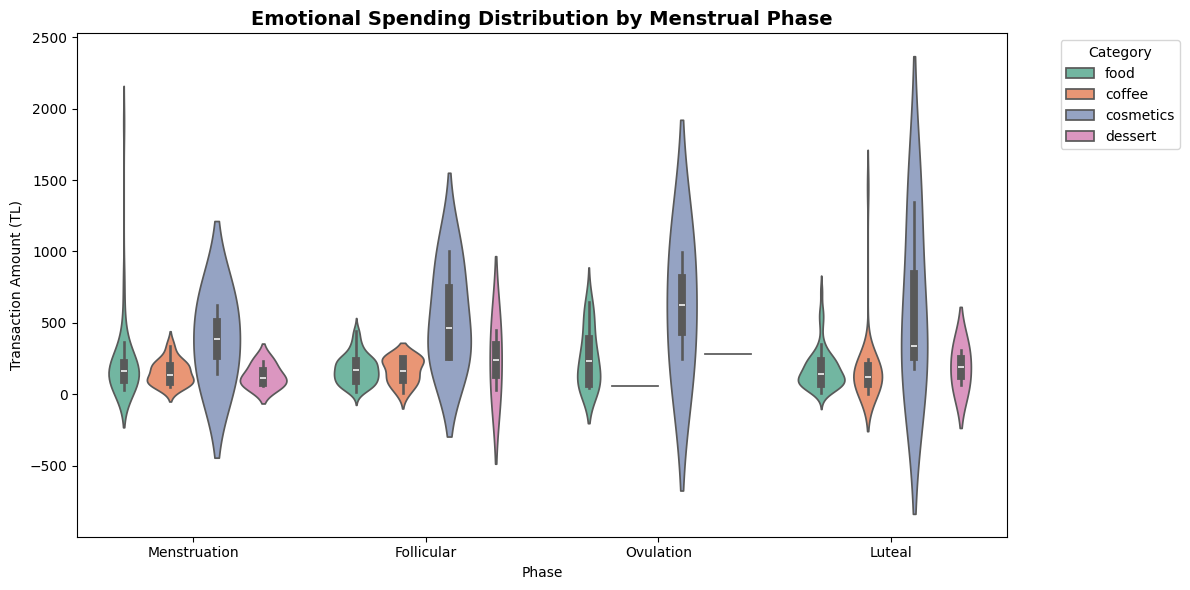

In [ ]:
phase_order = ["Menstruation", "Follicular", "Ovulation", "Luteal"]

# --- emotional spending categories ---
emotional_cats = ["dessert", "cosmetics", "food", "coffee"]

# --- filter the data---
filtered_emotional = merged[merged["Kategori"].isin(emotional_cats)].copy()
filtered_emotional = filtered_emotional[filtered_emotional["phase"].isin(phase_order)]
filtered_emotional["İşlem Tutarı*"] = filtered_emotional["İşlem Tutarı*"].abs()
filtered_emotional["phase"] = pd.Categorical(filtered_emotional["phase"], categories=phase_order, ordered=True)

# --- draw Violinplot  ---
plt.figure(figsize=(12, 6))
sns.violinplot(data=filtered_emotional, x="phase", y="İşlem Tutarı*", hue="Kategori", inner="box", palette="Set2")
plt.title("Emotional Spending Distribution by Menstrual Phase", fontsize=14, weight="bold")
plt.xlabel("Phase")
plt.ylabel("Transaction Amount (TL)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()



In [ ]:
dessert_data = merged[merged["Kategori"] == "dessert"]
print(dessert_data["phase"].value_counts())
luteal_desserts = dessert_data[dessert_data["phase"] == "Luteal"]
print(len(luteal_desserts))


phase
Menstruation    4
Luteal          2
Follicular      2
Unknown         1
Ovulation       1
Name: count, dtype: int64
2
